In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly
plotly.tools.set_credentials_file(username='quoniammm', api_key='IF7kV6idFRdoo7LdgGRp')
import plotly.plotly as py
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import nltk

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [6]:
sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


# 数据可视化

In [7]:
z = {'EAP': '爱伦坡', 'MWS': '玛丽雪莱', 'HPL': '洛夫克拉夫特'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='作家文选段落条目数'
    )]

layout = go.Layout(
    title='目标变量分布'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~quoniammm/0 or inside your plot.ly account where it is named 'basic-bar'


In [8]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~quoniammm/0 or inside your plot.ly account where it is named 'basic-bar'


In [9]:
eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values

(-0.5, 399.5, 199.5, -0.5)

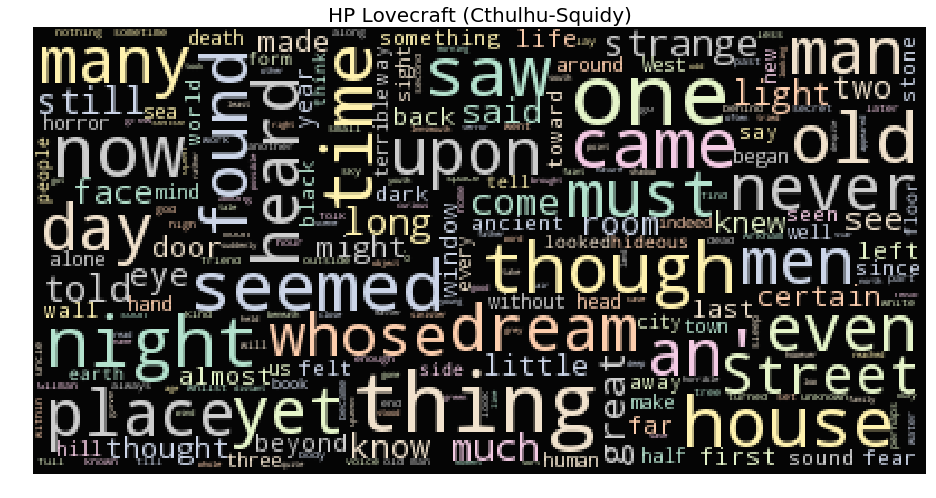

In [10]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

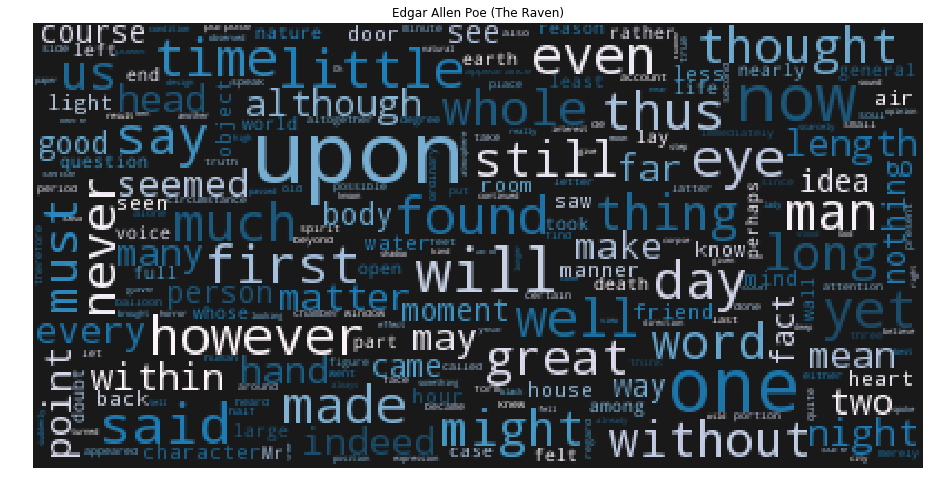

In [11]:
plt.figure(figsize=(20,18))
# The wordcloud of the raven for Edgar Allen Poe
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

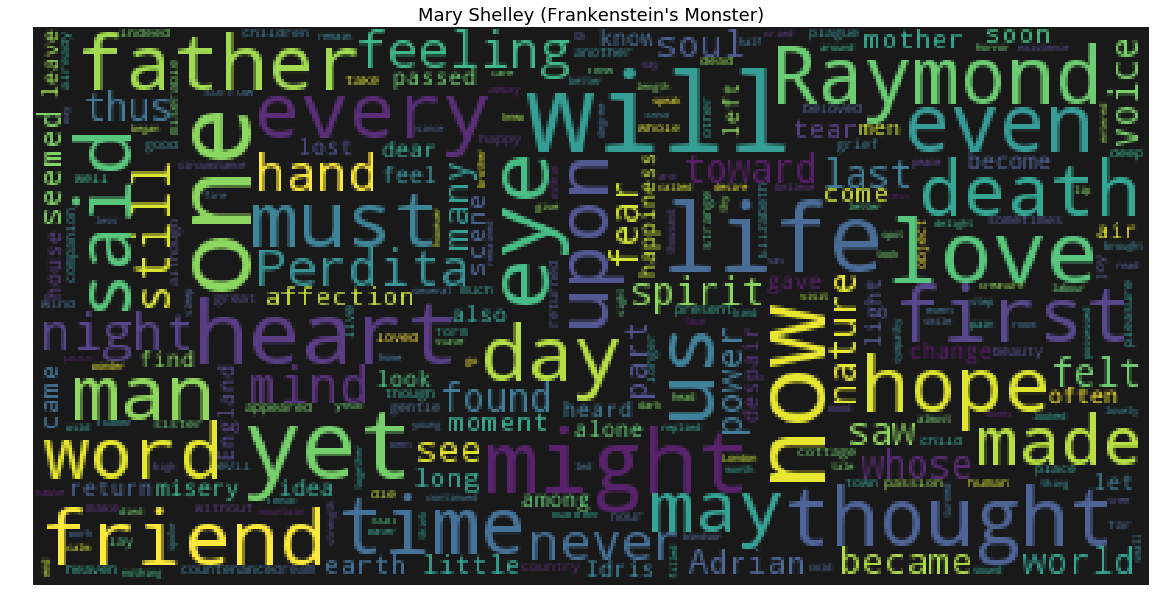

In [12]:
plt.figure(figsize=(20,18))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize= 18)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

# 自然语言处理

In [13]:
# tokenization(分词)
# stopword removal(高频词去除)
first_text = train.text.values[0]
first_text_list = nltk.word_tokenize(first_text)
stopwords = nltk.corpus.stopwords.words('english')
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
first_text_list

['This',
 'process',
 ',',
 'however',
 ',',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the',
 'dimensions',
 'of',
 'my',
 'dungeon',
 ';',
 'as',
 'I',
 'might',
 'make',
 'its',
 'circuit',
 ',',
 'and',
 'return',
 'to',
 'the',
 'point',
 'whence',
 'I',
 'set',
 'out',
 ',',
 'without',
 'being',
 'aware',
 'of',
 'the',
 'fact',
 ';',
 'so',
 'perfectly',
 'uniform',
 'seemed',
 'the',
 'wall',
 '.']

In [14]:
# stemming and lemmatization(词干提取)
stemmer = nltk.stem.PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [15]:
# vectorizer(向量化，为了机器可读)

In [16]:
# bag_words
all_words = set(train['text'].str.split(expand=True).unstack())

def wordandindex(vocab):
    return {word: i + 3 for i, word in enumerate(vocab)}, {i + 3: word for i, word in enumerate(vocab)}

word2index, index2word = wordandindex(all_words)

In [17]:
label_encoder = LabelEncoder()
# 数据集准备
X = np.array(train.text.apply(lambda sen: [word2index[word] for word in sen.split(' ')]))
y = np.array(label_encoder.fit_transform(train.author))
assert len(X) == len(y)
print(len(all_words))
print(len(train))
print("test length: {}".format(len(test)))
# 句子填充
X_pad = np.zeros((19579, 861))

for i in range(X_pad.shape[0]):
    for j in range(len(X[i])):
        X_pad[i, j] = X[i][j]

xtrain, xvalid, ytrain, yvalid = train_test_split(
    X_pad, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, 
    shuffle=True
)
print("train length: {}".format(len(xtrain)))
#print(xtrain.type)
print("valid length: {}".format(len(xvalid)))
#print(xvalid.type)

47557
19579
test length: 8392
train length: 17621
valid length: 1958


In [18]:
# 最长句子长度设置为 input_size
max = 0
for i, x in enumerate(X):
    # print(len(x))
    if len(x) > max:
        max = len(x)
        
print(max)
# train.iloc[9215].values

# 参数
input_size = 861
num_classes = 3
epochs = 20
lr = 1e-3

861


# 逻辑回归并不是很好

In [19]:
# 逻辑回归
class LR(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LR, self).__init__()
        self.linear_1 = nn.Linear(input_size, 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 64)
        self.linear_4 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        L1_out = F.relu(self.linear_1(x))
        L2_out = F.relu(self.linear_2(L1_out))
        L3_out = F.relu(self.linear_3(L2_out))
        final_out = F.log_softmax(self.linear_4(L3_out))
        logits = F.softmax(self.linear_4(L3_out))
        
        return final_out, logits
    
model = LR(input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [20]:
# 训练模型
for epoch in range(epochs):
    vx = Variable(torch.FloatTensor(xtrain))
    vy = Variable(torch.LongTensor(ytrain))
    for i in range(0, len(xtrain), 256):
        if i + 256 > len(xtrain):
            vx_batch = vx[i:len(xtrain)]
            vy_batch = vy[i:len(xtrain)]
        else:
            vx_batch = vx[i:i+256]
            vy_batch = vy[i:i+256]
            
        optimizer.zero_grad()
        outputs, _ = model(vx_batch)
#         print(outputs.size())
#         print(vy_batch.size())
        loss = criterion(outputs, vy_batch)
        loss.backward()
        optimizer.step()
        
    print(loss.data[0])

3.492755174636841
1.6519321203231812
1.1018482446670532
1.0996438264846802
1.0977452993392944
1.0961929559707642
1.095009446144104
1.0941780805587769
1.0936414003372192
1.093348503112793
1.0932320356369019
1.0892329216003418
1.0933212041854858
1.093276023864746
1.093580722808838
1.0937138795852661
1.0938349962234497
1.0939382314682007
1.0940357446670532
1.094102144241333


In [21]:
def test_deal(x):
    sen_vec = []
    for word in x.split(' '):
        if word not in all_words:
            sen_vec.append(47558)
        else:
            sen_vec.append(word2index[word])
            
    return sen_vec
            
X_t = np.array(test.text.apply(test_deal))

X_t_pad = np.zeros((8392, 861))

for i in range(X_t_pad.shape[0]):
    for j in range(len(X_t[i])):
        X_t_pad[i, j] = X_t[i][j]

In [22]:
_, result = model(Variable(torch.FloatTensor(X_t_pad)))
r = result.data.numpy()

In [23]:
rr = pd.DataFrame(r, columns=['EAP', 'HPL', 'MWS'], index=test.id)

In [24]:
rr.head()

,EAP,HPL,MWS
id,,,
id02310,0.398931,0.290266,0.310803
id24541,0.398931,0.290266,0.310803
id00134,0.398931,0.290266,0.310803
id27757,0.398931,0.290266,0.310803
id04081,0.398931,0.290266,0.310803


In [25]:
sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [26]:
rr.to_csv('one.csv')

# 深度学习技术

### Hierarchical Attention Networks for Document Classification

In [35]:
# Functions to accomplish attention

def batch_matmul_bias(seq, weight, bias):
    s = None
    bias_dim = bias.size()
    for i in range(seq.size(0)):
        _s = torch.mm(seq[i], weight) 
        _s_bias = _s + bias.expand(bias_dim[0], _s.size()[0]).transpose(0,1)
        _s_bias = torch.tanh(_s_bias)
        _s_bias = _s_bias.unsqueeze(0)
        if(s is None):
            s = _s_bias
        else:
            s = torch.cat((s,_s_bias),0)
    return s

def batch_matmul(seq, weight):
    s = None
    for i in range(seq.size(0)):
        _s = torch.mm(seq[i], weight)
        _s = _s.unsqueeze(0)
        if(s is None):
            s = _s
        else:
            s = torch.cat((s,_s),0)
    return s.squeeze()

def attention_mul(rnn_outputs, att_weights):
    attn_vectors = None
    for i in range(rnn_outputs.size(0)):
        h_i = rnn_outputs[i]
        a_i = att_weights[i].unsqueeze(1).expand_as(h_i)
        h_i = a_i * h_i
        h_i = h_i.unsqueeze(0)
        if(attn_vectors is None):
            attn_vectors = h_i
        else:
            attn_vectors = torch.cat((attn_vectors,h_i),0)
    return torch.sum(attn_vectors, 0)

In [36]:
# Hierarchical Attention Networks for Document Classification
class AttentionWordRNN(nn.Module):
    def __init__(self, batch_size, num_tokens, embed_size, word_gru_hidden, n_classes):
        super(AttentionWordRNN, self).__init__()
        
        self.num_tokens = num_tokens
        self.embed_size = embed_size
        self.word_gru_hidden = word_gru_hidden
        self.batch_size = batch_size
        
        # (N, W) => (N, W, embed_size)
        self.lookup = nn.Embedding(num_tokens, embed_size)
        # (seq_len, batch, input_size) + (num_layers * num_directions, batch, hidden_size)
        # => (seq_len, batch, hidden_size * num_directions) + (num_layers * num_directions, batch, hidden_size)
        self.word_gru = nn.GRU(embed_size, word_gru_hidden)
        self.softmax_word = nn.Softmax()
        self.final_softmax = nn.LogSoftmax()
        # ???
        self.final_linear = nn.Linear(word_gru_hidden, n_classes)
        
        self.weight_W_word = nn.Parameter(torch.Tensor(word_gru_hidden, word_gru_hidden))
        self.bias_word = nn.Parameter(torch.Tensor(word_gru_hidden,1))
        self.weight_proj_word = nn.Parameter(torch.Tensor(word_gru_hidden, 1))
        
        self.weight_W_word.data.uniform_(-0.1, 0.1)
        self.weight_proj_word.data.uniform_(-0.1,0.1)
    
    def forward(self, x, state_word):
        # embeddings
        embedded = self.lookup(x)
        embedded_resize = embedded.view(-1, self.batch_size, self.embed_size)
        # word level gru
        output_word, state_word = self.word_gru(embedded_resize, state_word)
        # print(output_word.size())
        word_hidden = batch_matmul_bias(output_word, self.weight_W_word, self.bias_word)
        # print(word_hidden.size())
        word_similarity = batch_matmul(word_hidden, self.weight_proj_word)
        # print(word_similarity.size())
        word_weights = self.softmax_word(word_similarity.transpose(1, 0))
        # print(word_weights)
        sen_vector = attention_mul(output_word, word_weights.transpose(1, 0))
        # print(sen_vector)
        final_linear = self.final_linear(sen_vector)
        out = self.final_softmax(final_linear)
        
        return F.softmax(final_linear), out, state_word
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.batch_size, self.word_gru_hidden))

In [45]:
# 训练
model = AttentionWordRNN(10, 47558, 256, 128, 3)
hidden = model.init_hidden()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [46]:
epochs = 1
# 训练模型
for epoch in range(epochs):
    vx = Variable(torch.LongTensor(xtrain.astype(int)))
    vy = Variable(torch.LongTensor(ytrain))
    for i in range(0, len(xtrain)-1, 10):
        vx_batch = vx[i:i+10]
        vy_batch = vy[i:i+10]
        print(vx_batch.size())
        optimizer.zero_grad()
        _, outputs, next_hidden = model(vx_batch, hidden)
        hidden = next_hidden
#         print(outputs.size())
#         print(vy_batch.size())
        loss = criterion(outputs, vy_batch)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        print(loss.data[0])

torch.Size([10, 861])


KeyboardInterrupt: 

In [ ]:
_, result = model(Variable(torch.FloatTensor(X_t_pad)))
r = result.data.numpy()

In [ ]:
for epoch in range(epochs):
    results = np.array([])
    vx = Variable(torch.LongTensor(X_t_pad.astype(int)))
    for i in range(0, len(X_t_pad), 10):
        vx_batch = vx[i:i+10]
        print(vx_batch.size())    
        result, _, _ = model(vx_batch, hidden)

In [331]:
model = AttentionWordRNN(2, 100, 20, 20, 3)

In [319]:
x = Variable(torch.floor(torch.rand(2, 10)*9).type(torch.LongTensor))
print(x.type)
init = model.init_hidden()
model(x, init)

<bound method Variable.type of Variable containing:
    5     6     3     2     8     8     8     6     8     7
    3     3     0     1     3     7     8     7     4     4
[torch.LongTensor of size 2x10]
>
torch.Size([10, 2, 20])
torch.Size([10, 2, 20])
torch.Size([10, 2])
Variable containing:
 0.1000  0.1006  0.0997  0.0996  0.0997  0.1001  0.0999  0.1002  0.0997  0.1004
 0.1001  0.1004  0.0996  0.1006  0.1000  0.1002  0.1000  0.0998  0.0995  0.1000
[torch.FloatTensor of size 2x10]

Variable containing:

Columns 0 to 9 
-0.1655 -0.1371 -0.3258  0.2220  0.4530 -0.0975 -0.0319 -0.3808  0.0944 -0.0863
-0.1737 -0.1951 -0.2044 -0.0779  0.3007 -0.1324 -0.3761 -0.2312 -0.1111  0.3872

Columns 10 to 19 
 0.0601 -0.1766  0.0742  0.0062  0.2991 -0.4741 -0.1618  0.2633  0.0062 -0.1212
 0.0957  0.0062  0.3009 -0.0646  0.1192 -0.1222 -0.1604 -0.1235  0.0424 -0.2502
[torch.FloatTensor of size 2x20]



Variable containing:
 0.2818  0.3178  0.4004
 0.3048  0.3614  0.3337
[torch.FloatTensor of size 2x3]

In [320]:
s = torch.rand(9, 3, 5)
w = torch.rand(5, 5)
w1 = torch.rand(5, 1)
b = torch.rand(5, 1)
ss = batch_matmul_bias(s, w, b)

In [321]:
ss.size()

torch.Size([9, 3, 5])

In [322]:
s = torch.rand(1, 4, 5)
s2 = torch.rand(1, 4, 5)
sss = torch.cat((s, s2), 0)

In [323]:
sss.size()

torch.Size([2, 4, 5])

In [324]:
s = torch.rand(9, 3, 5)
w = torch.rand(5, 5)
w1 = torch.rand(5, 1)
b = torch.rand(5, 1)

In [325]:
a = F.softmax(batch_matmul(s, w1))
a[0]

Variable containing:
 0.3583
 0.3090
 0.3327
[torch.FloatTensor of size 3]

In [326]:
a[0].unsqueeze(1).expand_as(torch.rand(3, 5))

Variable containing:
 0.3583  0.3583  0.3583  0.3583  0.3583
 0.3090  0.3090  0.3090  0.3090  0.3090
 0.3327  0.3327  0.3327  0.3327  0.3327
[torch.FloatTensor of size 3x5]

In [327]:
a = torch.rand(9, 3, 5)
b = torch.sum(a, 0)
b.size()

torch.Size([3, 5])

In [328]:
torch.ceil(torch.rand(2, 10)*100)


   33    76    72    48     1     3    53    23    85    84
   88    88    47    61    26    47    93    14    75    41
[torch.FloatTensor of size 2x10]

In [329]:
np.array(torch.rand(2, 10)*100)

array(

Columns 0 to 7 
 79.3451  19.7294   3.6730  95.8092  60.5555   6.8698  98.6816   1.7559
  8.2315  81.9254  11.2149  37.8706  85.5708   9.9544  37.8996  15.4472

Columns 8 to 9 
 18.4864  89.4557
 21.0955   0.5120
[torch.FloatTensor of size 2x10]
, dtype=object)